# Cell type annotation from marker genes

In single-cell, we have no prior information of which cell type each cell belongs.
To assign cell type labels, we first project all cells in a shared embedded space, 
then we find communities of cells that show a similar transcription profile and finally
we check what cell type specific markers are expressed. If more than one marker
gene is available, statistical methods can be used to test if a set of markers is
enriched in a given cell population.

In this notebook we showcase how to use `decoupler` for cell type annotation with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

or local execution on a MacOS - modifications by adeslatt*

be sure to run the pseudobulk.ipynb notebook first. set up the scverse environment and install packages
using the scverse conda environment -- add this if you haven't already done so.


```bash
pip install leidenalg
```

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc
import numpy as np

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Single-cell processing

### Loading the data-set

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### QC, projection and clustering


Here we follow the standard pre-processing steps as described in the [scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).
These steps carry out the selection and filtration of cells based on 
quality control metrics and the data normalization.

<div class="alert alert-info">

**Note**
    
This is just an example, these steps should change depending on the data.

</div> 

In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

/Users/annedeslattesmays/miniconda3/envs/scverse/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Then we group cells based on the similarity of their transcription profiles. 
To visualize the communities we perform UMAP reduction.

/var/folders/30/3sg2nxpx01n8zhgzmfp539mh0000gn/T/ipykernel_48259/1393200769.py:21: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


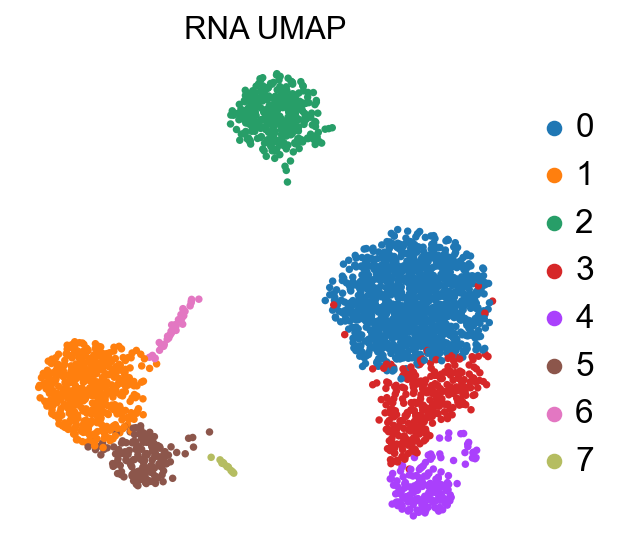

In [4]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

At this stage, we have identified communities of cells that show a similar 
transcriptomic profile, and we would like to know to which cell type they 
probably belong.

## Marker genes

To annotate single cell clusters, we can use cell type specific marker genes. 
These are genes that are mainly expressed exclusively by a specific cell type, 
making them useful to distinguish heterogeneous groups of cells. Marker genes were
discovered and annotated in previous studies and there are some resources that
collect and curate them.

[Omnipath](https://omnipathdb.org/) is one of the largest available databases of 
curated prior knowledge. Among its resources, there is 
[PanglaoDB](https://panglaodb.se/), a database of cell type markers, 
which can be easily accessed using a wrapper to Omnipath from `decoupler`. 

<div class="alert alert-info">

**Note**
    
If you encounter bugs with `Omnipath`, sometimes is good to just remove its cache using: `rm $HOME/.cache/omnipathdb/*` 

</div> 

In [5]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


Since our data-set is from human cells, and we want best quality of the markers, we can filter by `canonical_marker` and `human`:

In [6]:
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
14,PRSS3,True,Acinar cells,Endoderm,True,0.833333,0.028931,True,0.028571,0.000000,9606,Pancreas,0.006
15,CELA3A,True,Acinar cells,Endoderm,True,0.833333,0.000000,True,0.128571,0.000000,9606,Pancreas,0.001
17,PRSS1,True,Acinar cells,Endoderm,True,1.000000,0.005975,True,0.028571,0.000000,9606,Pancreas,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,TRBC2,True,T cells,Mesoderm,True,0.940711,0.083362,True,0.000000,0.000000,9606,Immune system,0.066
8266,TRAC,True,T cytotoxic cells,Mesoderm,True,1.000000,0.131348,True,0.000000,0.000000,9606,Immune system,0.042
8267,TRAC,True,T cells,Mesoderm,True,0.972332,0.059544,True,0.000000,0.000000,9606,Immune system,0.042
8297,LCK,True,T cells,Mesoderm,True,0.648221,0.033004,True,0.705607,0.030902,9606,Immune system,0.048


For this example we will use these markers, but any collection of genes could be used. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

## Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.get_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [7]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 36 sources.


  0%|          | 0/2638 [00:00<?, ?it/s]

The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

In [8]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Dendritic cells,Ductal cells,Endothelial cells,Enterocytes,Ependymal cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACATACAACCAC-1,-0.000000,1.356127,0.885021,4.065376,2.641014,5.720316,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,0.885021,2.538999,0.437907,1.871866,-0.000000,-0.0,-0.0,-0.0,11.728494
AAACATTGAGCTAC-1,-0.000000,-0.000000,0.885021,5.618952,13.894150,13.010816,0.885021,0.827013,-0.000000,-0.000000,...,-0.0,0.885021,5.279244,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581
AAACATTGATCAGC-1,-0.000000,0.530653,0.885021,1.542530,6.107693,4.530375,-0.000000,0.298770,-0.000000,-0.000000,...,-0.0,2.171878,2.538999,0.437907,3.976687,-0.000000,-0.0,-0.0,-0.0,11.728494
AAACCGTGCTTCCG-1,0.613213,0.530653,0.885021,2.703919,2.641014,22.778754,0.885021,0.827013,-0.000000,0.885021,...,-0.0,0.885021,2.538999,-0.000000,8.019237,0.613213,-0.0,-0.0,-0.0,1.957728
AAACCGTGTATGCG-1,-0.000000,-0.000000,0.885021,1.542530,0.943623,9.831072,-0.000000,0.298770,0.795482,-0.000000,...,-0.0,0.885021,0.569257,0.437907,2.858756,-0.000000,-0.0,-0.0,-0.0,1.957728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.613213,1.356127,0.885021,4.065376,2.641014,25.194302,0.885021,1.527899,-0.000000,-0.000000,...,-0.0,0.885021,2.538999,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581
TTTCTACTGAGGCA-1,-0.000000,-0.000000,0.885021,4.065376,2.641014,8.373145,2.171878,0.827013,-0.000000,-0.000000,...,-0.0,0.885021,8.735716,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581
TTTCTACTTCCTCG-1,-0.000000,-0.000000,0.885021,9.375833,17.770927,14.738433,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,-0.000000,3.822062,1.146495,2.858756,-0.000000,-0.0,-0.0,-0.0,2.981581
TTTGCATGAGAGGC-1,-0.000000,-0.000000,-0.000000,5.618952,7.468516,11.376327,-0.000000,-0.000000,0.795482,0.885021,...,-0.0,0.885021,1.443226,1.146495,2.858756,-0.000000,-0.0,-0.0,-0.0,2.981581


## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [9]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 2638 × 36
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

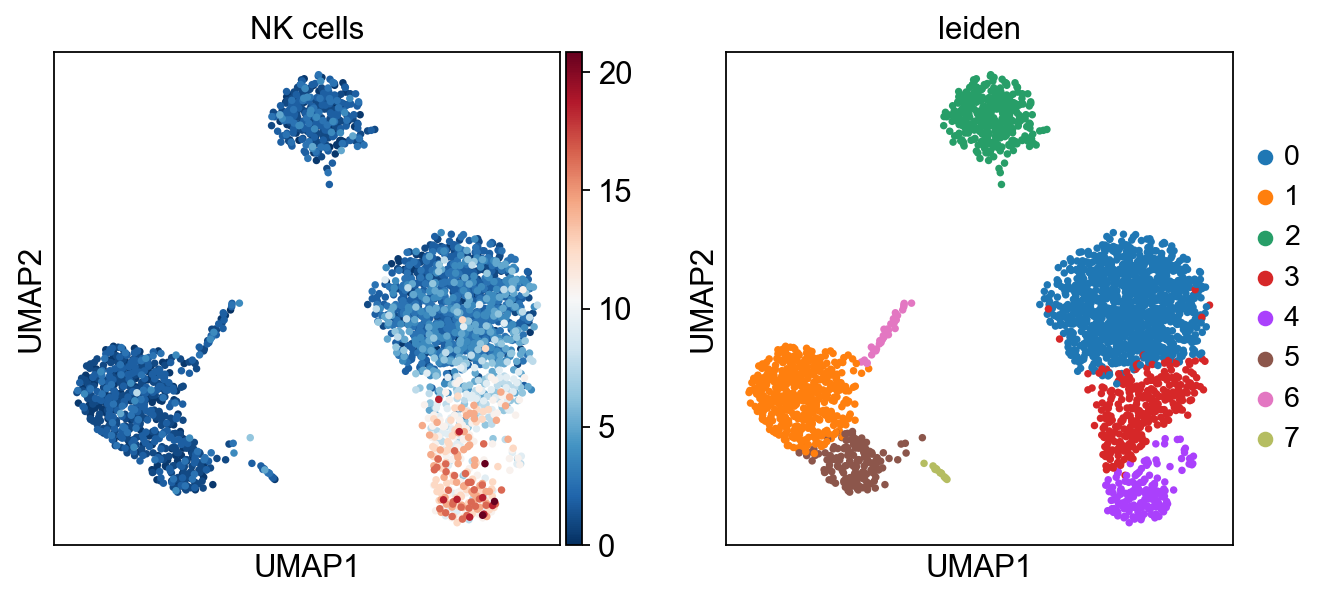

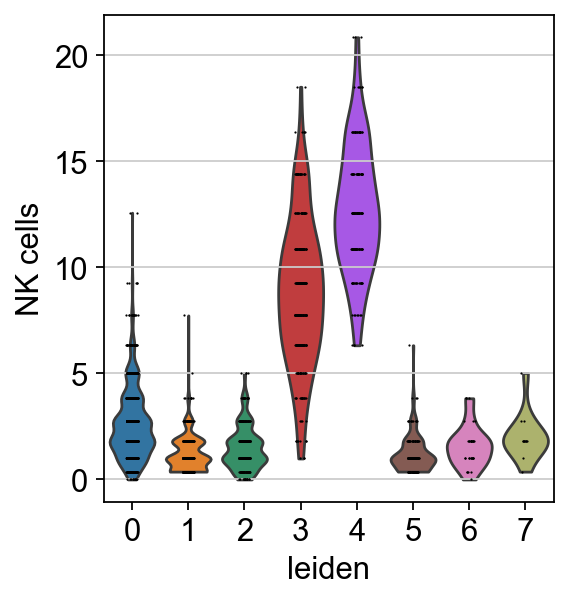

In [10]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

The cells highlighted seem to be enriched by NK cell marker genes.

## Annotation

With `decoupler` we can also identify which are the top predicted cell types per cluster using the 
function `dc.rank_sources_groups`. Here, it identifies "marker" cell types per cluster using
same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

In [11]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,41.437629,5.485775,9.089575e-280,3.272247e-278
1,0,rest,Neurons,8.374429,0.154858,9.752419e-17,2.194294e-16
2,0,rest,Pericytes,4.103715,0.084454,4.208916e-05,6.887318e-05
3,0,rest,Erythroid-like and erythroid precursor cells,3.783625,0.051813,1.585674e-04,2.481925e-04
4,0,rest,Oligodendrocytes,2.840025,0.035810,4.551524e-03,5.851959e-03
...,...,...,...,...,...,...,...
283,7,rest,Adipocytes,-2.059547,-0.352965,5.536047e-02,1.107209e-01
284,7,rest,B cells naive,-2.718910,-2.860703,1.690495e-02,3.803615e-02
285,7,rest,B cells,-2.878208,-1.926988,9.934033e-03,2.750963e-02
286,7,rest,Ductal cells,-3.456581,-0.625260,3.285144e-03,1.130539e-02


We can then extract the top 3 predicted cell types per cluster:

In [12]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T cells', 'Neurons', 'Pericytes'],
 '1': ['Neutrophils', 'Dendritic cells', 'Acinar cells'],
 '2': ['B cells naive', 'B cells', 'Plasma cells'],
 '3': ['NK cells', 'Gamma delta T cells', 'T cells'],
 '4': ['Gamma delta T cells', 'NK cells', 'Hepatic stellate cells'],
 '5': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 '6': ['Dendritic cells', 'Ductal cells', 'Acinar cells'],
 '7': ['Platelets', 'Pancreatic stellate cells', 'Endothelial cells']}

We can visualize the obtained top predicted cell types:

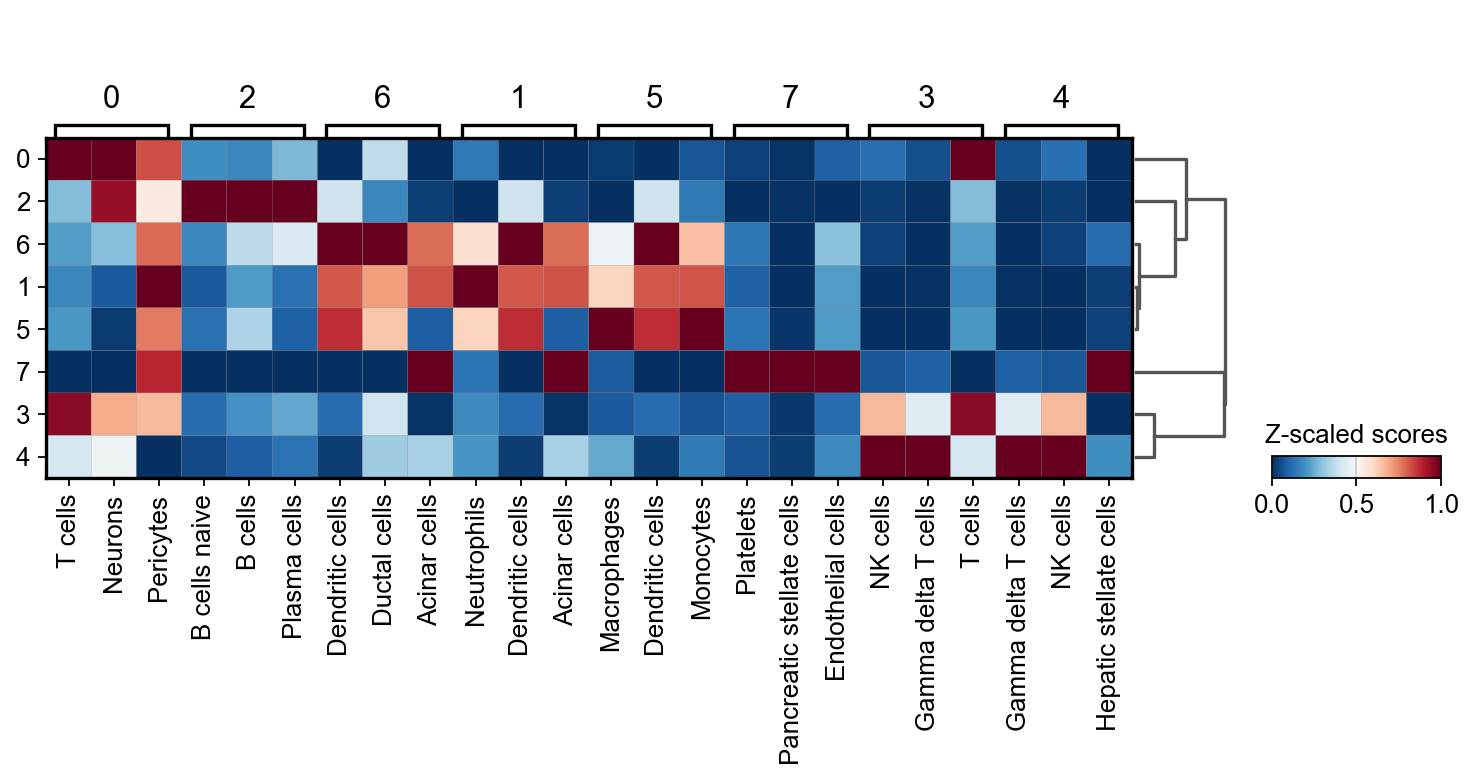

In [13]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

From this plot we see that cluster 7 belongs to Platelets, cluster 4 appear to be NK cells, custers 0 and 3 might be T-cells, cluster 2 should be some sort of B cells and that clusters 6,5 and 1 belong to the myeloid lineage.

We can check individual cell types by plotting their distributions:

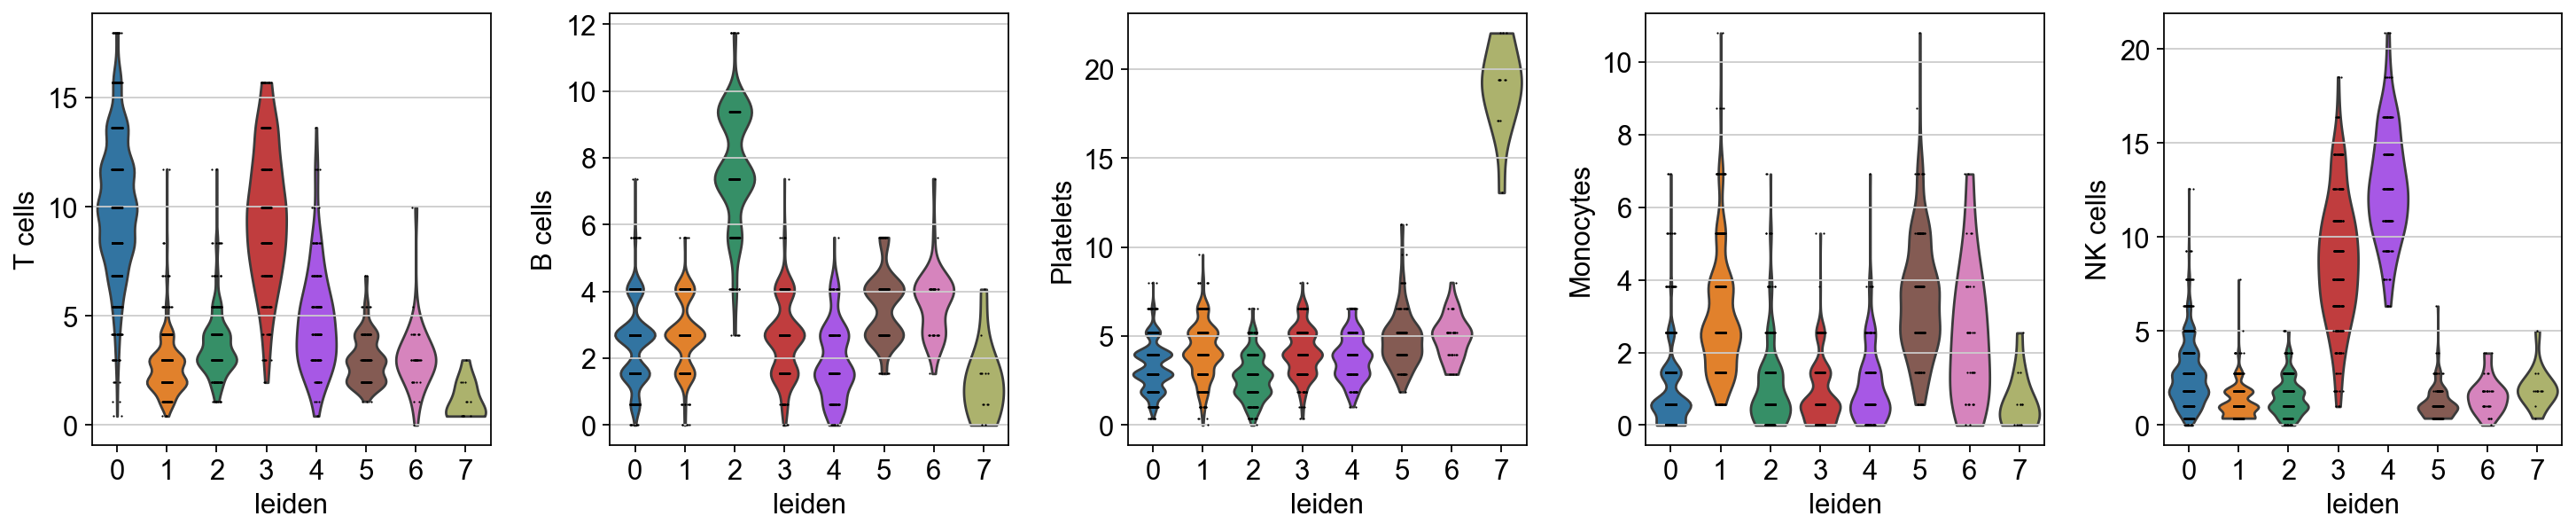

In [14]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

The final annotation should be done manually based on the assessment of the enrichment results. However, an automatic prediction can be made by assigning the top predicted cell type per cluster. This approach does not require expertise in the tissue being studied but **can be prone to errors**. Nonetheless it can be useful to generate a first draft, let's try it:

In [15]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'T cells',
 '1': 'Neutrophils',
 '2': 'B cells naive',
 '3': 'NK cells',
 '4': 'Gamma delta T cells',
 '5': 'Macrophages',
 '6': 'Dendritic cells',
 '7': 'Platelets'}

Once we have selected the top cell type we can finally annotate:

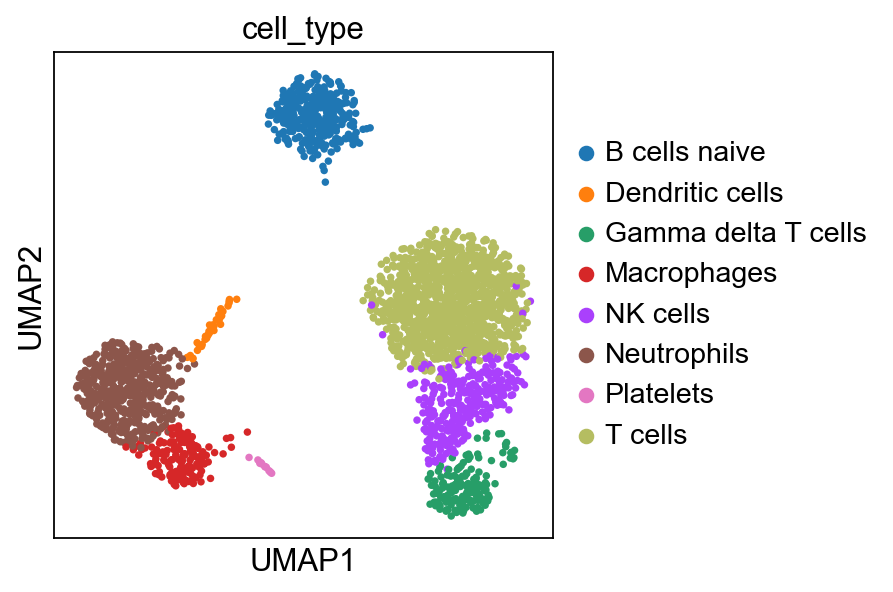

In [16]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

Compared to the annotation obtained by the `scanpy` tutorial, it is very similar but there are some errors, highlything the limitation of automatic annotation.

<img src="https://scanpy-tutorials.readthedocs.io/en/latest/_images/pbmc3k_100_1.png" width="300" height="300" />

<div class="alert alert-info">

**Note**

Cell annotation should always be revised by an expert in the tissue of interest, this notebook only shows how to generate a first draft of it.

</div> 